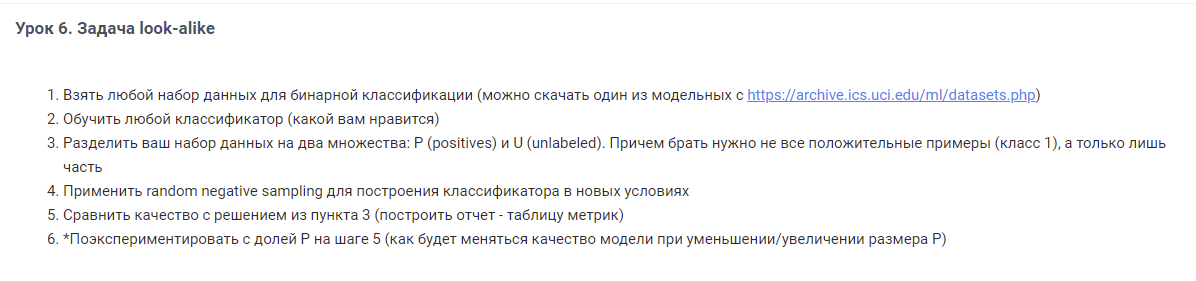

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')



### 1. Взял набор данных из предыдущего дз

In [3]:
df = pd.read_csv("churn_data.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Exited']), df['Exited'], random_state=0)

In [6]:
#соберем наш простой pipeline, для этого понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [8]:
# Определим признаки
nominative_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [9]:
# Под каждый признак создать трансформер и объединить их в список.

final_transformers = list()

for cat_col in nominative_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    
    final_transformers.append((cont_col, cont_transformer))

In [10]:
# Объединим в пайплайн
feats = FeatureUnion(final_transformers)

In [11]:
# Создадим модель
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

In [12]:
# обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [13]:
# наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [14]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [16]:
# создадим таблицу метрик
metrics_df = pd.DataFrame(columns=['model', 'thresh', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC


In [17]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.38, F-Score=0.641, Precision=0.653, Recall=0.629


In [18]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.8635016710758334

In [19]:
metrics_df = metrics_df.append({
    'model': 'supervised',
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,supervised,0.38,0.640641,0.653061,0.628684,0.863502


### 3. Разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные примеры (класс 1), а только лишь часть

In [20]:
mod_data = X_train.copy()
mod_data['Exited'] = y_train
mod_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2967,2968,15595324,Daniels,579,Germany,Female,39,5,117833.30,3,0,0,5831.00,1
700,701,15803457,Hao,750,France,Female,32,5,0.00,2,1,0,95611.47,0
3481,3482,15644686,Kennedy,729,Spain,Female,34,9,53299.96,2,1,1,42855.97,0
1621,1622,15777797,Kovalyova,689,Spain,Male,38,5,75075.14,1,1,1,8651.92,1
800,801,15747542,Perez,605,France,Male,52,7,0.00,2,1,1,173952.50,0


In [21]:
# Получим индексы для Р
pos_ind = mod_data[mod_data['Exited'] == 1].sample(frac=1, random_state=42).index

# Оставим только 25% от позитивно размеченых
perc = 0.25
pos_sample_len = int(np.ceil(perc * len(pos_ind)))

print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 382/1528 as positives and unlabeling the rest


In [22]:
# Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())
mod_data.head(3)

target variable:
 -1    7118
 1     382
Name: class_test, dtype: int64


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,class_test
2967,2968,15595324,Daniels,579,Germany,Female,39,5,117833.30,3,0,0,5831.00,1,-1
700,701,15803457,Hao,750,France,Female,32,5,0.00,2,1,0,95611.47,0,-1
3481,3482,15644686,Kennedy,729,Spain,Female,34,9,53299.96,2,1,1,42855.97,0,-1


#### 4. Применить random negative sampling для построения классификатора в новых условиях

In [23]:
mod_data = mod_data.sample(frac=1, random_state=42)


data_N = mod_data[mod_data['class_test'] == -1]
data_P = mod_data[mod_data['class_test'] == 1]

neg_sample = data_N[:data_P.shape[0]]
pos_sample = data_P.copy()

print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1, random_state=42)
sample_train.head(3)

(382, 15) (382, 15)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,class_test
2421,2422,15574842,Lorenzo,653,Germany,Female,25,2,158266.42,3,1,1,199357.24,0,-1
5828,5829,15684419,Wallace,709,Spain,Female,37,8,0.00,3,1,0,71738.56,0,-1
1117,1118,15592583,Colman,731,France,Female,47,1,115414.19,3,0,0,191734.67,1,1


In [24]:
sample_train.loc[sample_train['class_test'] == -1, 'class_test'] = 0

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])


pipeline.fit(sample_train.drop(columns=['class_test','Exited']), 
             sample_train['class_test'])

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [25]:
# наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.72, 0.39, 0.58, 0.42, 0.19, 0.8 , 0.15, 0.17, 0.38, 0.6 ])

In [26]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Лучшая отсечка={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Лучшая отсечка=0.58, F-Score=0.554, Precision=0.489, Recall=0.639


In [27]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.8059154209660564

In [28]:
metrics_df = metrics_df.append({
    'model': 'pu-learning',
    'thresh': thresholds[ix],
    'F-Score': fscore[ix],
    'Precision': precision[ix],
    'Recall': recall[ix],
    'ROC AUC': roc_auc
}, ignore_index=True)

#### 5. Сравнить качество с решением из пункта 3 (построить отчет - таблицу метрик)

In [29]:
metrics_df

,model,thresh,F-Score,Precision,Recall,ROC AUC
0,supervised,0.38,0.640641,0.653061,0.628684,0.863502
1,pu-learning,0.58,0.554135,0.489458,0.638507,0.805915
